In [40]:
%load_ext autoreload
%autoreload 2
from __future__ import print_function
from orphics import maps,io,cosmology,stats
from sotools import enmap
import numpy as np
import os,sys

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [252]:
"""
This part just loads a deep56 array into memory and 
calculates the 2D noise from splits using a canned orphics function.
"""

mroot = "/home/msyriac/data/act/maps/mr3/"
sroot = "/home/msyriac/data/act/maps/steve/"

season = "s15"
array = "pa3"
freq = "150"
region = "deep56"

smask = enmap.read_map(sroot+"deep56_forecast_180223_master_apo_w0.fits")
shape,wcs = smask.shape,smask.wcs
splits = []
invmaps = []

for split in range(4):
    splits.append(enmap.read_map(mroot+"%s_%s_%s_f%s_nohwp_night_3pass_4way_set%d_map_srcfree.fits" % (season,region,array,freq,split))[0])
    invmaps.append(enmap.read_map(mroot+"%s_%s_%s_f%s_nohwp_night_3pass_4way_set%d_ivar.fits" % (season,region,array,freq,split)))

splits = enmap.enmap(np.stack(splits),wcs)
invmaps = enmap.enmap(np.stack(invmaps),wcs)

Ny,Nx = splits.shape[-2:]

pmaps = (splits*invmaps*smask).reshape((4,1,Ny,Nx))
n2d,_ = maps.noise_from_splits(pmaps,do_cross=False)


0
1
2
3
(4, 2182, 9455) (4, 2182, 9455)
(4, 1, 2182, 9455)


In [271]:
"""
Example call for noise averaging
"""
import tilec as t
nfit,nparams = t.noise_average(n2d,dfact=(16,16),lmin=300,
                               lmax=8000,wnoise_annulus=500,bin_annulus=20,
                               lknee_guess=3000,alpha_guess=-4,
                               verbose=True,method="fft",nparams=nparams)

(2182, 9455)


/home/msyriac/repos/tilec/tilec.py:45: RuntimeWarning: divide by zero encountered in true_divide
  atm_factor = (lknee*np.nan_to_num(1./ells))**(-alpha) if lknee>1.e-3 else 0.
/home/msyriac/repos/tilec/tilec.py:45: RuntimeWarning: overflow encountered in multiply
  atm_factor = (lknee*np.nan_to_num(1./ells))**(-alpha) if lknee>1.e-3 else 0.


Resampling...


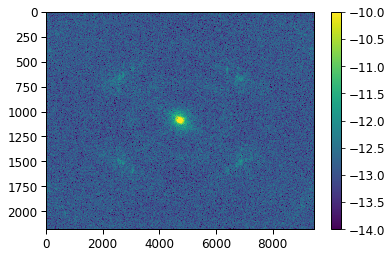

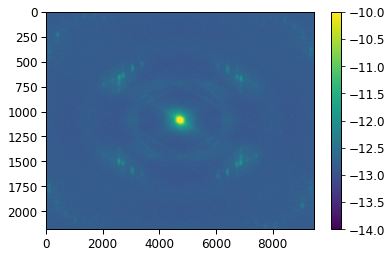

In [272]:
io.plot_img(np.log10(np.fft.fftshift(n2d)),aspect='auto',lim=[-14,-10])
io.plot_img(np.log10(np.fft.fftshift(nfit)),aspect='auto',lim=[-14,-10])

In [159]:
modlmap = enmap.modlmap(splits.shape,splits.wcs)

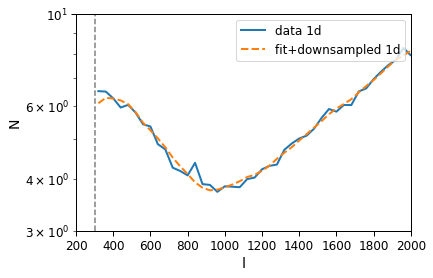

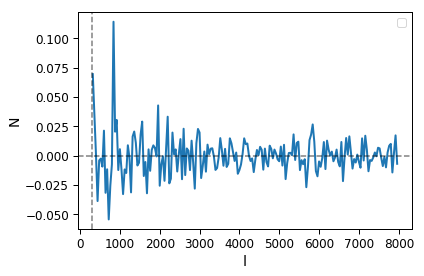

In [274]:
nout = nfit
bin_edges = np.arange(300,8000,40)
binner = stats.bin2D(modlmap,bin_edges)
cents,d1d = binner.bin(n2d)
cents,o1d = binner.bin(nout)
pl = io.Plotter(yscale='log',xlabel='l',ylabel='N')
pl.add(cents,d1d*cents**4.,lw=2,label='data 1d')
pl.add(cents,o1d*cents**4.,ls="--",lw=2,label='fit+downsampled 1d')
pl.vline(x=300)
pl.legend(loc='upper right')
pl._ax.set_ylim(3e0,1e1)
pl._ax.set_xlim(200,2000)
pl.done()

pl = io.Plotter(xlabel='l',ylabel='N')
pl.add(cents,(d1d-o1d)/o1d,lw=2)
pl.vline(x=300)
pl.legend(loc='upper right')
pl.hline()
pl.done()


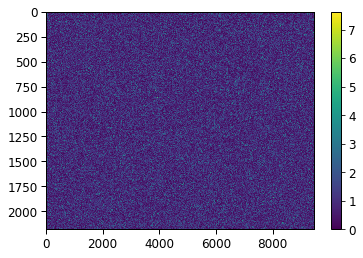

In [275]:
nres = n2d/nout
io.plot_img(np.fft.fftshift(nres),aspect='auto')